<a href="https://colab.research.google.com/github/natiska/ai4trees-height/blob/main/JDI_GC_split_in_tiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Splitting the data into tiles with patchify

In [31]:
import os
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np

In [12]:
import patchify

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  87482      0 --:--:-- --:--:-- --:--:-- 87482
OK
25 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 12.1 MB of archives.
After this operation, 27.5 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 155676 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.41.5_amd64.deb ...
Unpacking gcsfuse (0.41.5) ...
Setting up gcsfuse (0.41.5) ...


In [47]:
!mkdir -p justdiggit-drone-data
!gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 justdiggit-drone justdiggit-drone-data

2022/08/20 03:35:17.820933 Start gcsfuse/0.41.5 (Go version go1.18.4) for app "" using mount point: /content/justdiggit-drone-data
2022/08/20 03:35:17.837223 Opening GCS connection...
2022/08/20 03:35:18.223663 Mounting file system "justdiggit-drone"...
2022/08/20 03:35:18.224607 File system has been successfully mounted.


In [4]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load example data


In [107]:
year = '2019'
village = 'ikengwa'
DRIVE_path = '/content/drive/MyDrive/AI for Trees Share/01. Data'
example_DSM_path = f'{DRIVE_path}/justdiggit-drone-data/DSM/converted/{village}.tiff'

In [13]:
image = gdal.Open(example_DSM_path).ReadAsArray()

In [14]:
image.shape

(10061, 9942)

## Generate patches from it

In [29]:
patches = patchify.patchify(image, (256, 256), step=256)

In [30]:
patches.shape

(39, 38, 256, 256)

### Inspect one patch

In [108]:
x = 10
y = 8

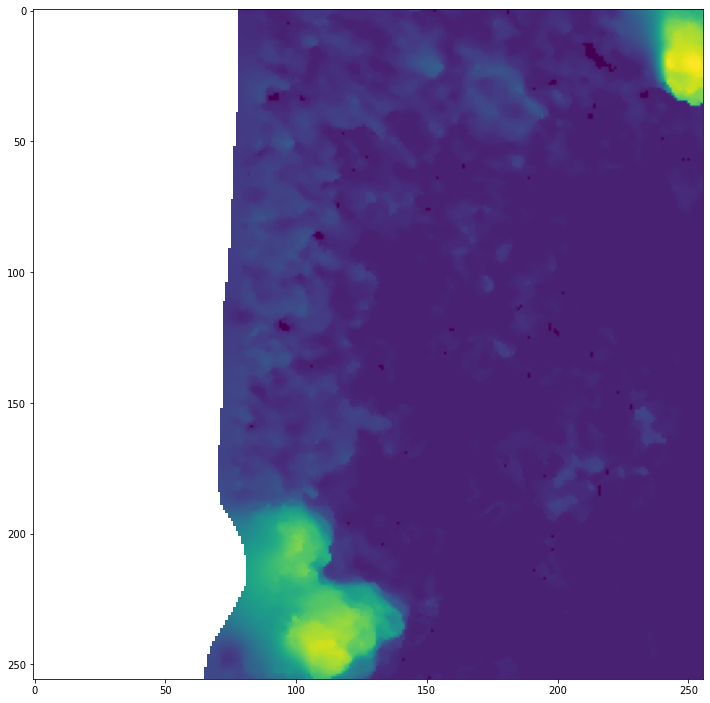

In [109]:
plt.figure(figsize=(12,16))
plot = plt.imshow(patches[x,y,:,:])
plt.show()

### Check if the patch looks identical to its manually specified equivalent

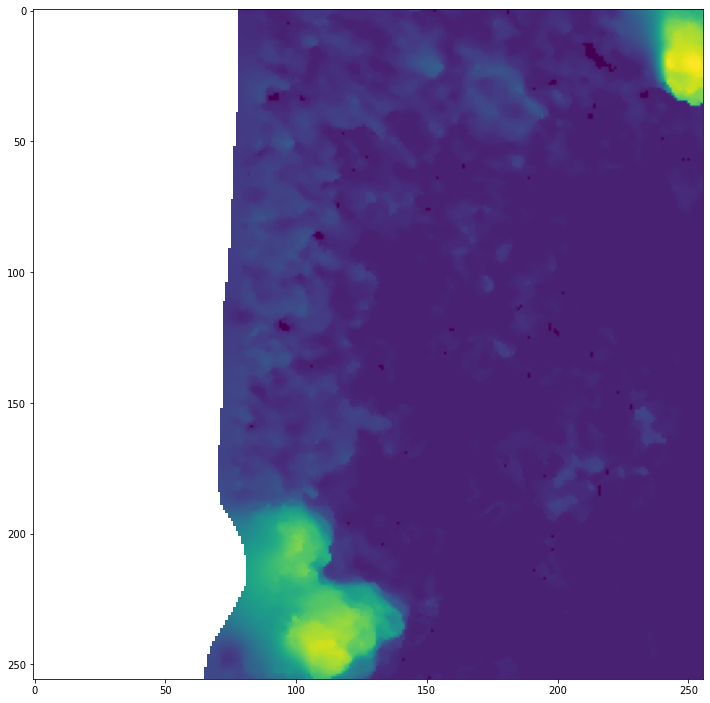

In [110]:
plt.figure(figsize=(12,16))
plot = plt.imshow(image[256*x:256*(x+1),256*y:256*(y+1)])
plt.show()

### Calculate percentage of valid datapoints

In [111]:
p = patches[x,y,:,:]

In [112]:
np.round((~np.isnan(p)).sum()/p.size, 2)

0.71

## Pack all into function

In [104]:
def generate_patches_from_single_image(image_path, patch_size, step, content_threshold, output_path):
  image = gdal.Open(image_path).ReadAsArray()
  print(f"Processing image {image_path}...")
  patches = patchify.patchify(image, (patch_size, patch_size), step=step)
  num_of_patches = patches.shape[0]*patches.shape[1]
  print(f"Image divided into {num_of_patches} patches.")
  num_saved_patches = 0
  for px in range(patches.shape[0]):
    for py in range(patches.shape[1]):
      p = patches[px,py,:,:]
      content_percentage = np.round((~np.isnan(p)).sum()/p.size, 2)
      if content_percentage > content_threshold: # if valid data (not nan) makes more than empty_threshold % of pixels, then save the tile
        plt.imsave(os.path.join(output_path, f"tile_{px}_{py}.png"), p)
        num_saved_patches += 1
        #print(f"Saved patch {px}_{py} with content percentage {content_percentage}.")
      else:
        #print(f"Dropping patch {px}_{py} with content percentage {content_percentage}, which is lower than threshold {content_threshold}.")
        continue
  print(f"Finished processing. {num_saved_patches} patches out of {num_of_patches} saved.")

## Test on a single file

In [113]:
example_output_path = f'{DRIVE_path}/justdiggit-drone-data/DSM/tiles/{year}/{village}'

In [114]:
if os.path.exists(example_output_path) == False:
  os.makedirs(example_output_path)

In [93]:
patch_size = 256
step = patch_size
content_threshold = 0.5

In [115]:
generate_patches_from_single_image(example_DSM_path, patch_size, step, content_threshold, example_output_path)

Processing image /content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/converted/ikengwa.tiff...
Image divided into 1482 patches.
Finished processing. 521 patches out of 1482 saved.


## Run on all files

In [102]:
FULL_IMAGES_PATH = f'{DRIVE_path}/justdiggit-drone-data/DSM/converted'
TILES_PATH = f'{DRIVE_path}/justdiggit-drone-data/DSM/tiles'

In [106]:
for filename in os.listdir(FULL_IMAGES_PATH):
  image_path = os.path.join(FULL_IMAGES_PATH, filename)
  village = filename.split(".")[0]
  output_path = os.path.join(TILES_PATH, f'2019/{village}')
  if os.path.exists(output_path) == False:
    os.makedirs(output_path)
  generate_patches_from_single_image(image_path, patch_size, step, content_threshold, output_path)

Processing image /content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/converted/ikengwa.tiff...
Image divided into 1482 patches.
Finished processing. 521 patches out of 1482 saved.
Processing image /content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/converted/kisima.tiff...
Image divided into 1600 patches.
Finished processing. 554 patches out of 1600 saved.
Processing image /content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/converted/loo.tiff...
Image divided into 2162 patches.
Finished processing. 584 patches out of 2162 saved.
Processing image /content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/converted/mapango.tiff...
Image divided into 1369 patches.
Finished processing. 539 patches out of 1369 saved.
Processing image /content/drive/MyDrive/AI for Trees Share/01. Data/justdiggit-drone-data/DSM/converted/bumila.tiff...
Image divided into 1296 patches.
Finished processing. 561 patches 